# Fake news detection

In [1]:
# Importig standard Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Train / Test split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

# Import the natural language toolkit library 
#!pip install nltk
import nltk
#nltk.download("punkt")
#nltk.download("stopwords")
from nltk.corpus import stopwords

# Text tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Loading the model and Ploting its architecture.
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

#Ploting the confusion matrix
from sklearn.metrics import confusion_matrix

**Importing the ISOT dataset files**

In [2]:
%matplotlib inline

# read the csv files
d_true = pd.read_csv("../Data/True.csv")
d_fake = pd.read_csv("../Data/Fake.csv")

### 1. EDA & DATA PREPROCESSING

In [3]:
d_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
d_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [5]:
d_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
d_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [7]:
# add a column with the name label that has value 1 for reliable news and 0 for fake news

d_true["label"] = 1
d_fake["label"] = 0

**True Dataset's WordCloud**

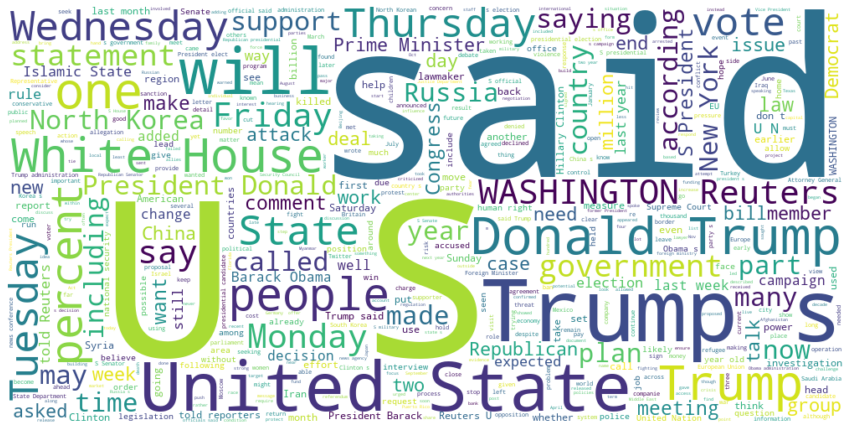

In [8]:
# plot the true dataset's wordcloud using top 500 words

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500, background_color="rgba(255, 255, 255, 0)", stopwords = STOPWORDS).generate(" ".join(d_true.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.savefig("../True dataset's world cloud.png", bbox_inches='tight')

**fake Dataset's WordCloud**

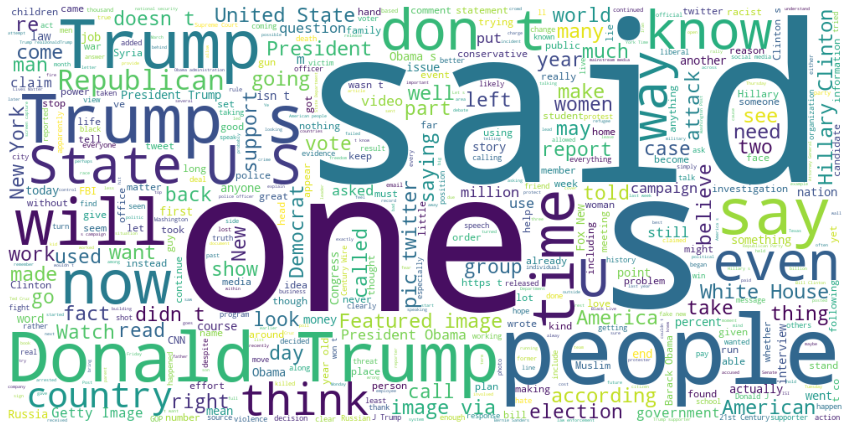

In [9]:
# plot the true dataset's wordcloud using top 500 words

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , background_color="rgba(255, 255, 255, 0)", stopwords = STOPWORDS).generate(" ".join(d_fake.text))
plt.imshow(wc)
plt.axis('off')
plt.savefig("../Fake dataset's world cloud.png", bbox_inches='tight')

In [10]:
# Concatenate the title with the article text

d_true['text'] = d_true['title'] +" "+ d_true['text']
d_fake['text'] = d_fake['title'] +" "+ d_fake['text']

In [11]:
# drop the unnecessary columns

d_true.drop(["title", "subject", "date"], axis=1, inplace= True)
d_fake.drop(["title", "subject", "date"], axis=1, inplace= True)

In [12]:
# concatenate the two dataframes and shuffle the result

data = pd.concat([d_true, d_fake], axis=0, ignore_index = True)
data = shuffle(data)

data = data.reset_index(drop= True)
data.head()

,text,label
0,Henningsen on White House Press Dinner: ‘The F...,0
1,China calls for restraint when asked about Nor...,1
2,"THE BIG QUESTION: Why Do We STILL Take 1,000 S...",0
3,Conservative Questions Loyalty Of Muslim Fath...,0
4,WATCH: Eric Trump Gets Called Out On Fox News...,0


In [13]:
# check if there is any null values

data.isnull().sum()

text     0
label    0
dtype: int64

In [14]:
data.shape

(44898, 2)

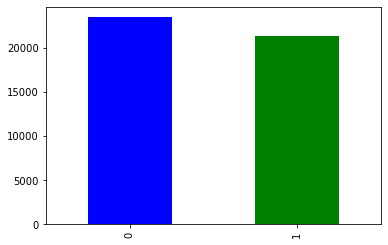

In [15]:
#check the data distribution

data.label.value_counts().plot(kind='bar', color=['b', 'g'])

In [16]:
#check the number of articles in each type (fake or true)
# 0 for fake and 1 for true

data.label.value_counts()

0    23481
1    21417
Name: label, dtype: int64

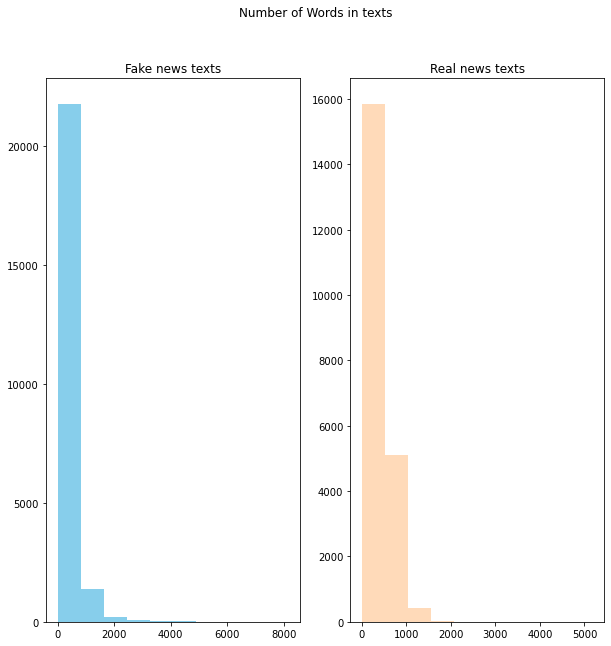

In [17]:
# plotting the number of words in texts

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news texts')

text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news texts')
fig.suptitle('Number of Words in texts')
plt.show()

#### TEXT PROCESSING WITH THE NLTK LIBRARY

In [18]:
# defining a function that takes care of cleaning stopwords and punctuations using nltk library.
stop_words = set(stopwords.words('english'))
def process(text):
    """Converting the texts into lowercase characters and removing punctuations and stopwords using the nltk library."""
    text = text.lower()
    words = nltk.word_tokenize(text)
    new_words= [word for word in words if word.isalnum() and word not in stop_words]
    text = " ".join(new_words)
    return text

In [19]:
# cleaning the text and seperating the target(label) variable and the feature(text) variable.
data = shuffle(data)

data['text'] = data['text'].apply(process)
X = data['text'].to_frame()
Y = data['label'].to_frame()

Text(0.5, 1.0, 'number of words')

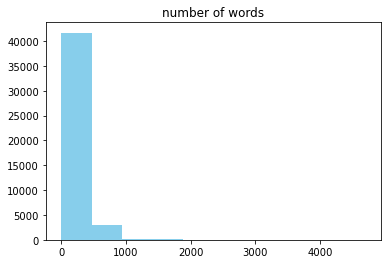

In [20]:
# Ploting the number of words after removing stopwords
text_len=X['text'].str.split().map(lambda x: len(x))
plt.hist(text_len,color='SkyBlue')
plt.title('number of words')

In [21]:
# Calculating the average number of words in the texts in order to use it as the length of sequences.
# Calculting the number of unique words in order to pass it as argument to the tensorflow tokenizer.

Avg_len = text_len.mean()
Avg_len = round(Avg_len)
lst = []
for i in X['text']:
    tmp = i.split()
    lst.extend(tmp)
lst = set(lst)
Vocab_size = len(lst)
print("the average number of words in the texts is : ", Avg_len)
print("the texts contains", Vocab_size, "unique words")

the average number of words in the texts is :  233
the texts contains 108192 unique words


### 2. TEXT TOKENIZATION

In [22]:
tokenizer = Tokenizer(num_words=Vocab_size)
tokenizer.fit_on_texts(X['text'])
sequences = tokenizer.texts_to_sequences(X['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108192 unique tokens.


In [23]:
# padding the sequences created by the tokenizer using the the average number of words in the texts + 2 = 235 as the maxlen.
# also setting up the truncation and the padding to be at the end of the sequence.

data = pad_sequences(sequences, maxlen=Avg_len+2, padding='post', truncating='post')

### 3. Spliting the data into train / test sets

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.25, random_state=30)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(33673, 235) (11225, 235) (33673, 1) (11225, 1)


### 4. Using GloVe for Word Embeddings

In [25]:
# Import tensor representations for words
# GloVe is an unsupervised learning algorithm for obtaining vector representations for words

embeddings_index = {};
with open("../../../glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((Vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;


100


In [26]:
print(embeddings_matrix.shape)

(108193, 100)


### 5. Building the architecture of the model

In [27]:
# Building the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 100, weights=[embeddings_matrix], trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         10819300  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,907,941
Trainable params: 88,641
Non-trainable params: 10,819,300
_________________________________________________________________


### 6. Model training

In [28]:
# using an early stop callback to stop the trainning if the loss function cannot be improved anymore.

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.1, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
948/948 [==============================] - 218s 221ms/step - loss: 0.3746 - accuracy: 0.8445 - val_loss: 0.0571 - val_accuracy: 0.9786
Epoch 2/10
948/948 [==============================] - 226s 238ms/step - loss: 0.0433 - accuracy: 0.9863 - val_loss: 0.0156 - val_accuracy: 0.9952
Epoch 3/10
948/948 [==============================] - 222s 235ms/step - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0116 - val_accuracy: 0.9976
Epoch 4/10
948/948 [==============================] - 202s 213ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.0108 - val_accuracy: 0.9976
Epoch 5/10
948/948 [==============================] - 219s 231ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0079 - val_accuracy: 0.9985
Epoch 6/10
948/948 [==============================] - 223s 236ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0083 - val_accuracy: 0.9985 - - ETA: 6s - loss: 0.0038 - ac
Epoch 7/10
948/948 [==============================] - 214s 226ms/step - loss: 0.0035 - accur

##### Save the model

In [29]:
model.save("../Model/model2.h5")

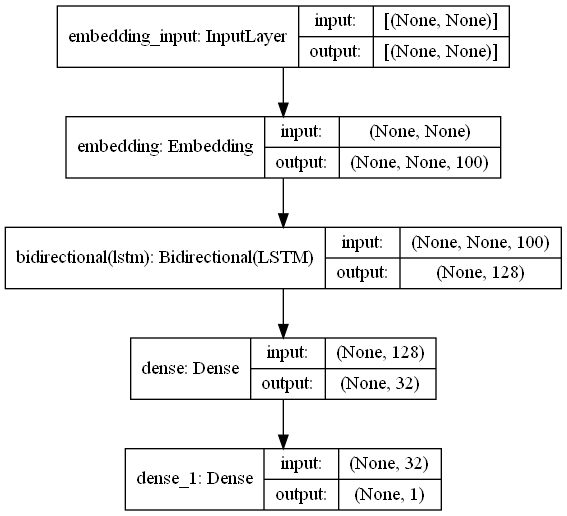

In [30]:
# Plotting the architecture of the model.

plot_model(model, to_file='../model_schema.png', show_shapes=True)

### 7. Model Evaluation

In [31]:
# loading the saved model.
model = load_model("../Model/model2.h5")

In [32]:
# evaluating the model with the evaluate method.
model.evaluate(X_test, Y_test)

351/351 [==============================] - 24s 65ms/step - loss: 0.0083 - accuracy: 0.99831s - loss: 0.0076 - accu - ETA: 0s - l


[0.008270232938230038, 0.9983073472976685]

In [33]:
# predict the labels of test set.
Y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [34]:
# Evaluating the model using sklearn metrics.

accuracy = accuracy_score(list(Y_test['label']), Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print("Model Accuracy : ", accuracy)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)

Model Accuracy :  0.9983073496659243
Precision on testing set: 0.9990573152337858
Recall on testing set: 0.997364953886693


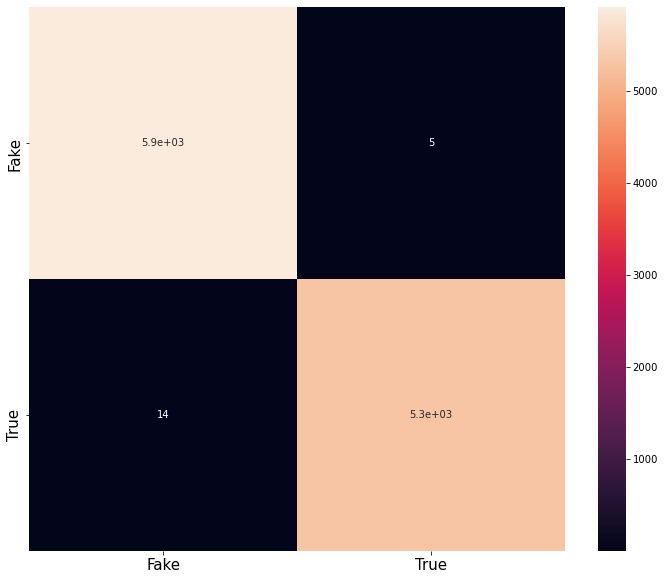

In [35]:
# Ploting the confusion matrix using the seaborn library

graph = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(graph, annot=True, ax = ax)
ax.xaxis.set_ticklabels(['Fake','True'], size=15)
ax.yaxis.set_ticklabels(['Fake','True'], size=15)
plt.savefig("../Confusion_matrix.png", bbox_inches='tight')